# Marketing Email Campaign

Different versions of marketing emails are sent to users. We would like to investigate the following questions. 

1. Percentages of users who opened and who clicked the link within the email. 
2. Different user segments. 
3. How to optimize future email campaign to improve clicke through rate (CTR), by modeling.  
3. Opportunity sizing, how much we can improve CTR, using modeling and AB testing. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
email = pd.read_csv('email/email_table.csv')
opened = pd.read_csv('email/email_opened_table.csv')
clicked = pd.read_csv('email/link_clicked_table.csv')

In [3]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
opened['opened']=1
clicked['clicked']=1
table = pd.merge(email,opened,on='email_id',how='left')
table = pd.merge(table,clicked,on='email_id',how='left')
table[['opened','clicked']] = table[['opened','clicked']].fillna(0).astype('int')

In [5]:
table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [6]:
print('Percentage of users who opened the email is {0:.2f}%'.format(table['opened'].sum()/table['opened'].count()*100))
print('Percentage of users who clicked the email is {0:.2f}%'.format(table['clicked'].sum()/table['clicked'].count()*100))

Percentage of users who opened the email is 10.35%
Percentage of users who clicked the email is 2.12%


### Let's now focus on CTR (percentage of users who clicked the email) and look into different user segments. 

In [7]:
# Useful functions
# Bar plot for discrete variable, split by a target column 

def barplot(df, var_col, tar_col, yscale='linear'):
    sns.countplot(x=var_col, hue=tar_col, data=df, order=df[var_col].value_counts().sort_index().index)
    plt.yscale(yscale)
    plt.ylabel('count',  fontsize=15)
    plt.xlabel(var_col, fontsize=15)
    plt.legend(fontsize=15)
    return 

# histogram for continuous variable, split by a target column
#kws={"histtype": "bar", "alpha": 0.3}
kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

def histplot(df, var_col, tar_col, binsize=20, yscale='linear'):
    tar_vals = df[tar_col].value_counts().index
    for tar_val in tar_vals:
        sns.distplot(df.loc[df[tar_col]==tar_val, var_col], bins=binsize, hist_kws=kws, kde=True, norm_hist=True, label=str(tar_val))
    plt.yscale(yscale)
    plt.ylabel('frequency',  fontsize=15)
    plt.xlabel(var_col, fontsize=15)
    plt.legend(fontsize=15)
    return 


# Single histogram for one category of target variable
def histplot_single(df, var_col, tar_col, tar_val, binsize=20, yscale='linear'):
    sns.distplot(df.loc[df[tar_col]==tar_val, var_col], bins=binsize, hist_kws=kws, kde=False, norm_hist=True, label=str(tar_val))
    plt.yscale(yscale)
    plt.ylabel('frequency',  fontsize=15)
    plt.xlabel(var_col, fontsize=15)
    plt.legend(fontsize=15)
    return 

# absolute count split by a 2-value target column, for different segments in a column, stacked bar plot 
def ctg_table(df, col, tar):
    df_cat = df[[tar, col]]
    contingency_table = pd.crosstab(
        df_cat[tar],
        df_cat[col],
        margins = True, dropna=False,
        normalize=False)
    categories = df[col].value_counts().index.tolist()
    n = len(categories)
    
    #Assigns the frequency values
    tar_vals = df[tar].value_counts().index.tolist()
    count1 = contingency_table.iloc[1][0:n].values
    count0 = contingency_table.iloc[0][0:n].values

    #Plots the bar chart
    p1 = plt.bar(categories, count1, 0.55, color='#d62728', label=tar_vals[1])
    p2 = plt.bar(categories, count0, 0.55, bottom=count1, label=tar_vals[0])
    plt.legend(fontsize=15)
    plt.xlabel(col, fontsize=15)
    return 


# ratio split by a 2-value target column, for different segments in a column, stacked bar plot 
def ctg_table_ratio(df, col, tar, axis=0):
    df_cat = df[[tar, col]]
    contingency_table = pd.crosstab(
        df_cat[tar],
        df_cat[col],
        margins = True, dropna=False,
        normalize=False)
    categories = df[col].value_counts().index.tolist()
    n = len(categories)

    if axis==0:
        contingency_table = contingency_table/contingency_table.iloc[-1,:]*100
    else:
        contingency_table.iloc[0] = contingency_table.iloc[0]/contingency_table.iloc[0,-1]*100
        contingency_table.iloc[1] = contingency_table.iloc[1]/contingency_table.iloc[1,-1]*100
        contingency_table.iloc[2] = contingency_table.iloc[2]/contingency_table.iloc[2,-1]*100    
        
    #Assigns the frequency values
    tar_vals = df[tar].value_counts().index.tolist()
    count1 = contingency_table.iloc[1][0:n].values
    count0 = contingency_table.iloc[0][0:n].values
    
    #Plots the bar chart
    p1 = plt.bar(categories, count1, 0.55, color='#d62728', label=tar_vals[1])
    p2 = plt.bar(categories, count0, 0.55, bottom=count1, label=tar_vals[0])
    plt.legend(fontsize=15)
    plt.xlabel(col, fontsize=15)
    return 



# segment users into groups and calculate conversion rate, also add another level of index: control vs treatment
def conversion_segments_ABtest(df, seg_col, test_col, conv_col):
    table = pd.pivot_table(df, values=conv_col, index=seg_col, columns=test_col, 
                           aggfunc=np.mean).rename_axis(None, axis=1).rename_axis(None, axis=0)
    table.plot(kind='bar')
    return table

# segment users into groups and calculate conversion rate, no split b/t control vs treatment
def conversion_segments(df, seg_col, conv_col):
    table = pd.pivot_table(df, values=conv_col, index=seg_col, 
                           aggfunc=np.mean).rename_axis(None, axis=1).rename_axis(None, axis=0)
    table.plot(kind='bar')
    return table

# calculate total user count and conversion rate for each segments 
def count_and_rate(df, seg_col, conv_col):
    t1 = df[[seg_col, conv_col]].groupby(seg_col).count().reset_index()
    t2 = df[[seg_col, conv_col]].groupby(seg_col).mean().reset_index()
    t3 = pd.merge(t1, t2, on=seg_col)
    t3.columns = [seg_col, 'count', 'rate']
    return t3            

def count_and_rate_plot(count_and_rate_table):
    sns.set(font_scale=1.2, palette='Set2')
    cols = count_and_rate_table.columns
    fig = plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(1,2,1)
    count_and_rate_table.plot(kind='bar', x=cols[0], y=cols[1], ax=ax1, legend=None)
    plt.xticks(rotation=45, fontsize=15, ha='center')
    plt.ylabel('Total count', fontsize=20)
    plt.xlabel(cols[0], fontsize=20)

    ax2 = fig.add_subplot(1,2,2)
    count_and_rate_table.plot(kind='bar', x=cols[0], y=cols[2], ax=ax2, legend=None)
    plt.xticks(rotation=45, fontsize=15, ha='center')
    plt.ylabel('Conversion rate', fontsize=20)
    plt.xlabel(cols[0], fontsize=20)
    return 
    

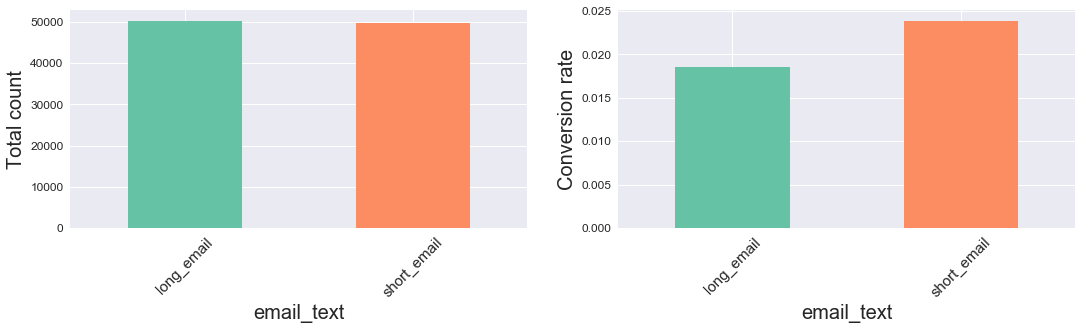

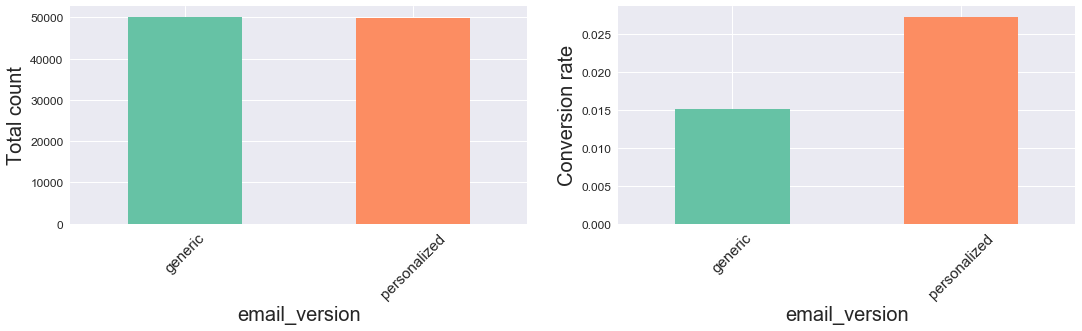

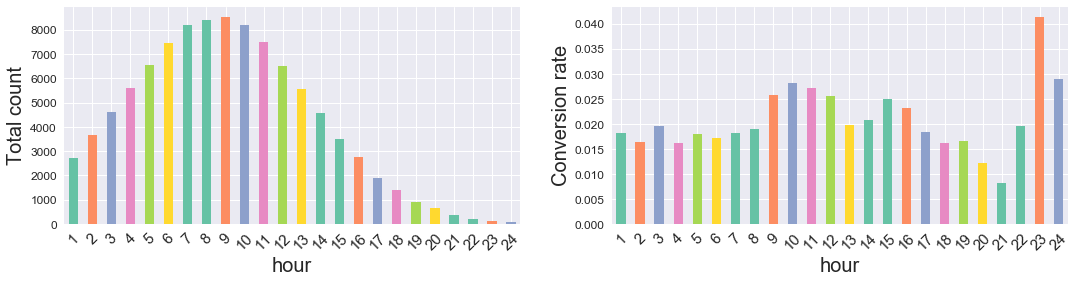

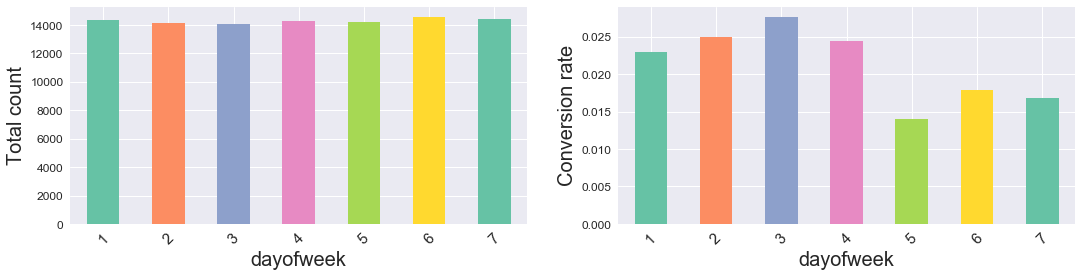

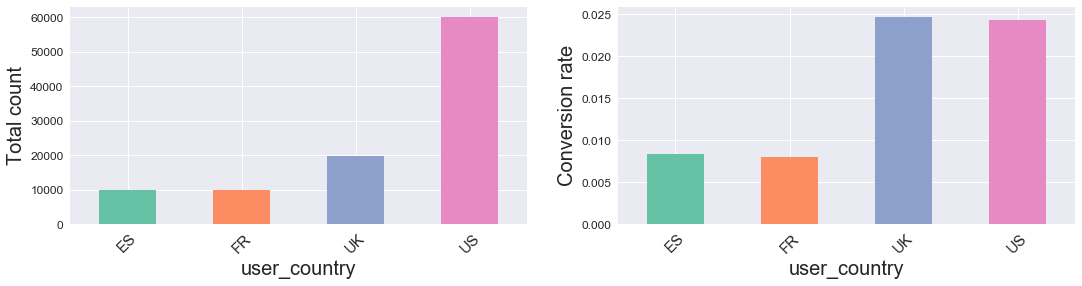

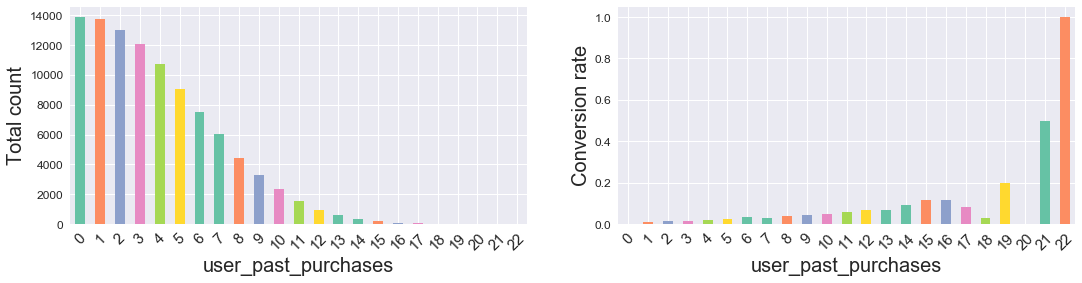

In [8]:
import calendar 
table['dayofweek'] = table['weekday'].map(dict(zip(calendar.day_name,range(1,8))))

sns.set(font_scale=1.2, palette='Set2')
cols = ['email_text', 'email_version', 'hour', 'dayofweek', 'user_country', 'user_past_purchases']
for col in cols:
    count_and_rate_plot(count_and_rate(table, col, 'clicked'))

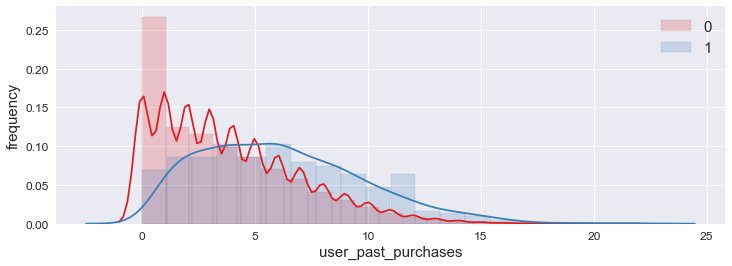

In [9]:
sns.set(font_scale=1.2, palette='Set1')
fig = plt.figure(figsize=(12,4))
histplot(table, 'user_past_purchases', 'clicked', binsize=20, yscale='linear')

### Short emails and personalized emails have higher CTR than long emails and generic emails. 

### Night time has higher CTR, but most of the emails are sent in the morning. We can send more emails at night time. 

### Early in the week has higher CTR. 

### US and UK have higher CTR than Spain and France. 

### Users who has more past purchases are more likely to click.

In [ ]:
# Categorical variable encoder

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()

cat_cols = ['email_text','email_version','weekday','user_country']

for col in cat_cols:
    table['{}_code'.format(col)] = le.fit_transform(table[col])

In [38]:
features = ['email_text_code','email_version_code','weekday_code','user_country_code', 'hour', 'user_past_purchases']
X = table[features]
y = table['clicked']


from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

def metrics(y, pred):
    accuracy = accuracy_score(y, pred)
    recall = recall_score(y, pred)
    precision = precision_score(y, pred)
    f1 = f1_score(y, pred)
    matrix = confusion_matrix(y, pred)
    FPR = matrix[0,1]/(matrix[0,1]+matrix[0,0])
    specificity = 1-FPR
    return specificity, recall, precision, f1

# Do a stratified train-test split

from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.5, random_state=0, shuffle=True, stratify=y )
print(len(y_train), len(y_holdout))
print(y_holdout.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))

50000 50000
0    0.97882
1    0.02118
Name: clicked, dtype: float64
0    0.9788
1    0.0212
Name: clicked, dtype: float64


In [51]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=100, min_samples_leaf=10, 
                            max_leaf_nodes=20, min_samples_split=2, class_weight='balanced')
#rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train,y_train)

pred_prob_train = rf.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, pd.DataFrame(pred_prob_train)[1])
print('ROC_AUC for train set is {}'.format(roc_auc_train))

pred_prob_holdout = rf.predict_proba(X_holdout)
roc_auc_holdout = roc_auc_score(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
print('ROC_AUC for test set is {}'.format(roc_auc_holdout))

print('specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set')
print(metrics(y_train, rf.predict(X_train)))
print('specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set')
print(metrics(y_holdout, rf.predict(X_holdout)))

ROC_AUC for train set is 0.9672638232413968
ROC_AUC for test set is 0.543094507485348
specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set
(0.9470984879444218, 0.7339622641509433, 0.23106623106623106, 0.3514795572622544)
specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set
(0.9467930773788847, 0.07271010387157696, 0.028720626631853787, 0.0411764705882353)


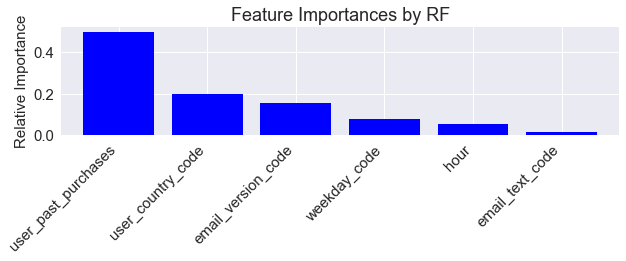

In [41]:
# Plot feature importance 

importances = pd.Series(dict(zip(X.columns.values, rf.feature_importances_))).sort_values(ascending=False)

sns.set(font_scale=1.5, palette='Set2')

fig = plt.figure()
plt.title('Feature Importances by RF', fontsize=18)
importances.plot(kind='bar', width=0.8, color='b', figsize=(10,2), fontsize=15, rot=0)
#plt.bar(importances[indices],  color='g', align='center')
#plt.xticks(range(len(indices)), [features[i] for i in indices], fontsize=15)
plt.ylabel('Relative Importance', fontsize=15)
plt.xticks(rotation=45,ha='right')
plt.yscale('linear')
plt.show()

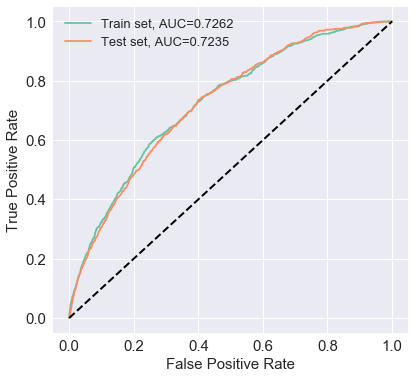

In [42]:
# Plot ROC_AUC curve for multiple cutoff dates

fpr_tr,tpr_tr,thresholds_tr = roc_curve(y_train, pd.DataFrame(pred_prob_train)[1])
roc_auc_tr = round(auc(fpr_tr, tpr_tr),4)

fpr_ts,tpr_ts,thresholds_ts = roc_curve(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
roc_auc_ts = round(auc(fpr_ts, tpr_ts),4)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
plt.plot(fpr_tr,tpr_tr,label='Train set, AUC={}'.format(roc_auc_tr))
plt.plot(fpr_ts,tpr_ts,label='Test set, AUC={}'.format(roc_auc_ts))
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(fontsize=13, frameon=False)

In [58]:
# XGBoost

from xgboost import XGBClassifier
from xgboost import plot_importance

xgb = XGBClassifier(random_state=2, max_depth=3, n_estimators=100, min_samples_leaf=10, max_leaf_nodes=20, 
                    min_samples_split=10, scale_pos_weight=50)
#xgb = XGBClassifier(scale_pos_weight=46)
xgb.fit(X_train, y_train)

pred_prob_train = xgb.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, pd.DataFrame(pred_prob_train)[1])
print('ROC_AUC for train set is {}'.format(roc_auc_train))

pred_prob_holdout = xgb.predict_proba(X_holdout)
roc_auc_holdout = roc_auc_score(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
print('ROC_AUC for test set is {}'.format(roc_auc_holdout))


print('specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set')
print(metrics(y_train, rf.predict(X_train)))
print('specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set')
print(metrics(y_holdout, rf.predict(X_holdout)))

ROC_AUC for train set is 0.772867527430585
ROC_AUC for test set is 0.7405354955251566
specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set
(0.9470984879444218, 0.7339622641509433, 0.23106623106623106, 0.3514795572622544)
specificity(1-FPR), sensitivity(1-FNR), precision, f1 for train set
(0.9467930773788847, 0.07271010387157696, 0.028720626631853787, 0.0411764705882353)


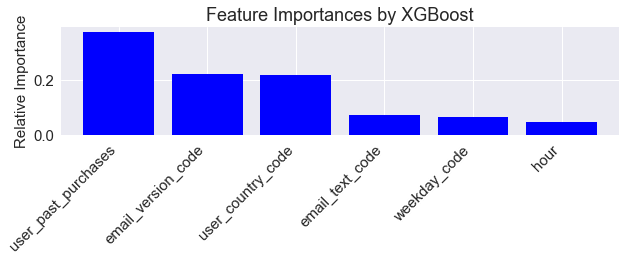

In [54]:
# Plot feature importance 

importances = pd.Series(dict(zip(X.columns.values, xgb.feature_importances_))).sort_values(ascending=False)

sns.set(font_scale=1.5, palette='Set2')

fig = plt.figure()
plt.title('Feature Importances by XGBoost', fontsize=18)
importances.plot(kind='bar', width=0.8, color='b', figsize=(10,2), fontsize=15, rot=0)
#plt.bar(importances[indices],  color='g', align='center')
#plt.xticks(range(len(indices)), [features[i] for i in indices], fontsize=15)
plt.ylabel('Relative Importance', fontsize=15)
plt.xticks(rotation=45,ha='right')
plt.yscale('linear')
plt.show()

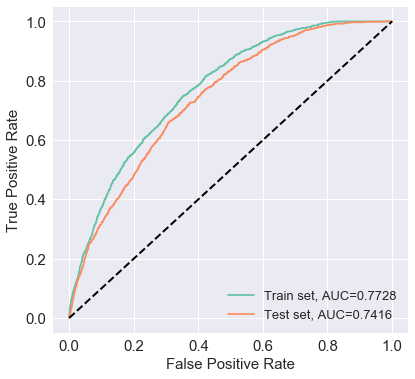

In [55]:
# Plot ROC_AUC curve for multiple cutoff dates

fpr_tr,tpr_tr,thresholds_tr = roc_curve(y_train, pd.DataFrame(pred_prob_train)[1])
roc_auc_tr = round(auc(fpr_tr, tpr_tr),4)

fpr_ts,tpr_ts,thresholds_ts = roc_curve(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
roc_auc_ts = round(auc(fpr_ts, tpr_ts),4)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
plt.plot(fpr_tr,tpr_tr,label='Train set, AUC={}'.format(roc_auc_tr))
plt.plot(fpr_ts,tpr_ts,label='Test set, AUC={}'.format(roc_auc_ts))
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(fontsize=13, frameon=False)

In [52]:
 0.97882/0.0212

46.170754716981136